## Analyzing Raw Data

In [1]:
## Import data
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

PRESSURE_PATH = '/Users/jiujiu/Desktop/496_New_Data/pressure/'   # pressure data
SATURATION_PATH = '/Users/jiujiu/Desktop/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/Users/jiujiu/Desktop/496_New_Data/production/' # production data
ROCK_PATH = '/Users/jiujiu/Desktop/496_New_Data/rock/'

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pullporosity(ROCK_PATH, index_list):
    data = []
    for i in index_list:
        temp_data = np.loadtxt(ROCK_PATH + '/rock'+str(i)+'.txt', delimiter=',')
        data.append(temp_data[[0]])
    data = np.float32(data)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
        
def animate_encoded(X,decoder,index_range):
    # sanity check on stacked encoded space
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
#     print(X.shape)
    decoded_X = decoder.predict(X[:,:,:,index_range])
#     print(decoded_X)
    for i in range(len(decoded_X)):
        ax1.clear()
        ax1.imshow(np.reshape(decoded_X[i],(60,220),order = 'F'))
        fig.canvas.draw()
        plt.pause(0.01)

<IPython.core.display.Javascript object>


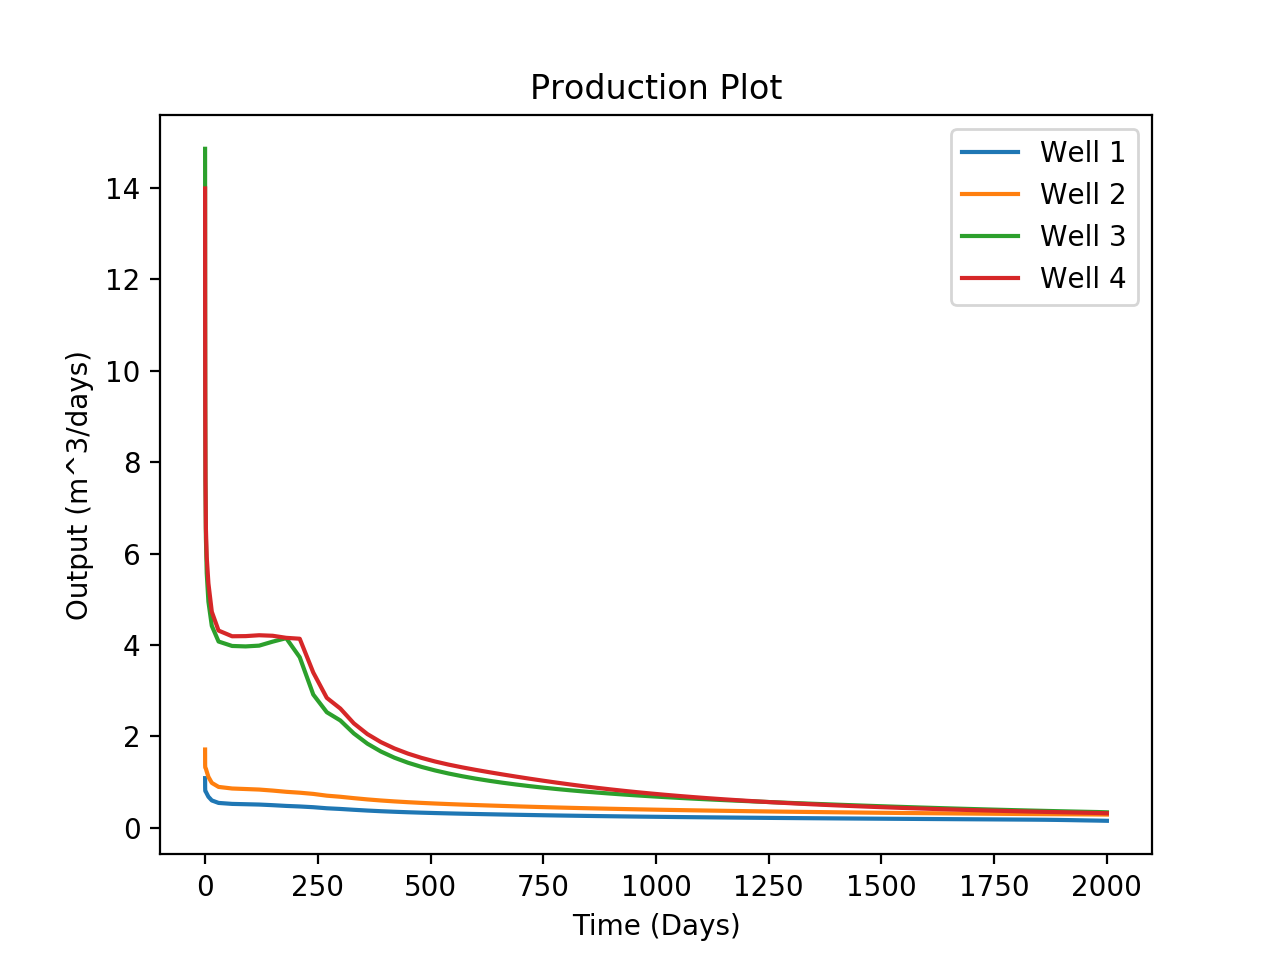

In [2]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + '/production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

## Pull Data and Reshape for CNN

In [3]:
# Specify files to read for testing and training
train_files = np.arange(1,81)
test_files = np.arange(81,101)

In [4]:
# pull porosity from Rock files
RTRAIN = pullporosity(ROCK_PATH, train_files)
RTEST = pullporosity(ROCK_PATH, test_files)
# reshape porosity data to feed into autoencoder (channel last)
Rtrain = RTRAIN
Rtest = RTEST
Rtrain_reshaped = np.reshape(Rtrain,(len(Rtrain), 60, 220, 1),order= 'F')
Rtest_reshaped = np.reshape(Rtest,(len(Rtest), 60, 220, 1),order= 'F')

In [5]:
# pull saturation data
STRAIN = pullseries(SATURATION_PATH, 'saturaton', train_files)
STEST = pullseries(SATURATION_PATH, 'saturaton', test_files)

Strain = STRAIN
Stest = STEST
Strain_reshaped = np.reshape(Strain,(len(Strain), 60, 220, 1),order= 'F')
Stest_reshaped = np.reshape(Stest,(len(Stest), 60, 220, 1),order= 'F')

In [ ]:
# pull pressure data
PTRAIN = pullseries(PRESSURE_PATH, 'pressure', train_files)
PTEST = pullseries(PRESSURE_PATH, 'pressure', test_files)
# scale original data
Ptrain, Pscaler = scale_data(PTRAIN) 
Ptest = Pscaler.transform(PTEST)
Ptrain_reshaped = np.reshape(Ptrain,(len(Ptrain), 60, 220, 1),order= 'F')
Ptest_reshaped = np.reshape(Ptest,(len(Ptest), 60, 220, 1),order= 'F')

In [ ]:
# sanity check for first pass of data
# here pressure data is checked
print(Ptrain_reshaped.shape)
interval = np.arange(75,150)
animate_single(Ptrain_reshaped[interval,])

## Autoencoders

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
# the constructer will instantiate the model as specified 
# (one model for each type of data)
def construct_autoencoder_model(channels_numbers):
    # tuple channel_numebers contain the channel numbers for 3 convolutional layers
    # default should be 16,8,8 / 4,2,1
    input_img = Input(shape=(60, 220, 1))  # y, x
    x = Conv2D(channels_numbers[0], (12, 44), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # encoded space (8,28,?)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[0], (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (12, 44), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoded_shape = autoencoder.layers[7].output.shape[1:]
    encoded_shape = tuple([int(encoded_shape[i]) for i in range(len(encoded_shape)) ])
#     autoencoder.summary()
    return autoencoder, encoded_shape

Using TensorFlow backend.


In [10]:
# just testing CNN structures
channels_numbers = (16,8,4)
input_img = Input(shape=(60, 220, 1))  # y, x
x = Conv2D(channels_numbers[0], (12, 44), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(channels_numbers[1], (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(channels_numbers[2], (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# encoded space (8,28,?)
x = Conv2D(channels_numbers[2], (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(channels_numbers[1], (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(channels_numbers[0], (5, 5), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (12, 44), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
encoded_shape = autoencoder.layers[7].output.shape[1:]
encoded_shape = tuple([int(encoded_shape[i]) for i in range(len(encoded_shape)) ])
autoencoder.summary()


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_3:0", shape=(?, 60, 220, 1), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: []

In [5]:
def train_autoencoder(model, iterations, TRAIN, TEST, name):
    # names: R for porosity, P for pressure, S for saturation
    model.fit(TRAIN, TRAIN,
                epochs = iterations,
                batch_size = 10,
                shuffle=True,
                validation_data=(TEST, TEST),
                verbose = 1)
    model.save(name+'autoencoder.h5')
    return model

In [6]:
# retreiving encoder and decoder from autoencoder
def retrieve_coders(name,encoded_shape):
    # check what encoded shape is first
    # default (8,28,8)
    autoencoder = load_model(name+'autoencoder.h5')
    encoded_input = Input(shape=encoded_shape)
    deco = autoencoder.layers[-7](encoded_input)
    deco = autoencoder.layers[-6](deco)
    deco = autoencoder.layers[-5](deco)
    deco = autoencoder.layers[-4](deco)
    deco = autoencoder.layers[-3](deco)
    deco = autoencoder.layers[-2](deco)
    deco = autoencoder.layers[-1](deco)
    # create the decoder model
    decoder = Model(encoded_input, deco)
    # decoder.summary()
#     decoder.summary()

    input_img = Input(shape=(60, 220, 1))
    enco = autoencoder.layers[1](input_img)
    enco = autoencoder.layers[2](enco)
    enco = autoencoder.layers[3](enco)
    enco = autoencoder.layers[4](enco)
    enco = autoencoder.layers[5](enco)
    enco = autoencoder.layers[6](enco)
    encoder = Model(input_img, enco)
#     encoder.summary()
    return decoder, encoder, autoencoder


In [12]:
####### EXAMPLE AUTOENCODER FOR ROCK #########
# construct autoencoder model
Rautoencoder, Rencoded_shape = construct_autoencoder_model((16,8,4))
# train autoencoder
Rautoencoder = train_autoencoder(Rautoencoder, 30, Rtrain_reshaped, Rtest_reshaped, 'R')
# retrieve encoder and decoder
Rdecoder, Rencoder, Rautoencoder = retrieve_coders('R', Rencoded_shape)

Train on 80 samples, validate on 20 samples
Epoch 1/30
20/80 [======>.......................] - ETA: 1:08 - loss: 0.6919

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


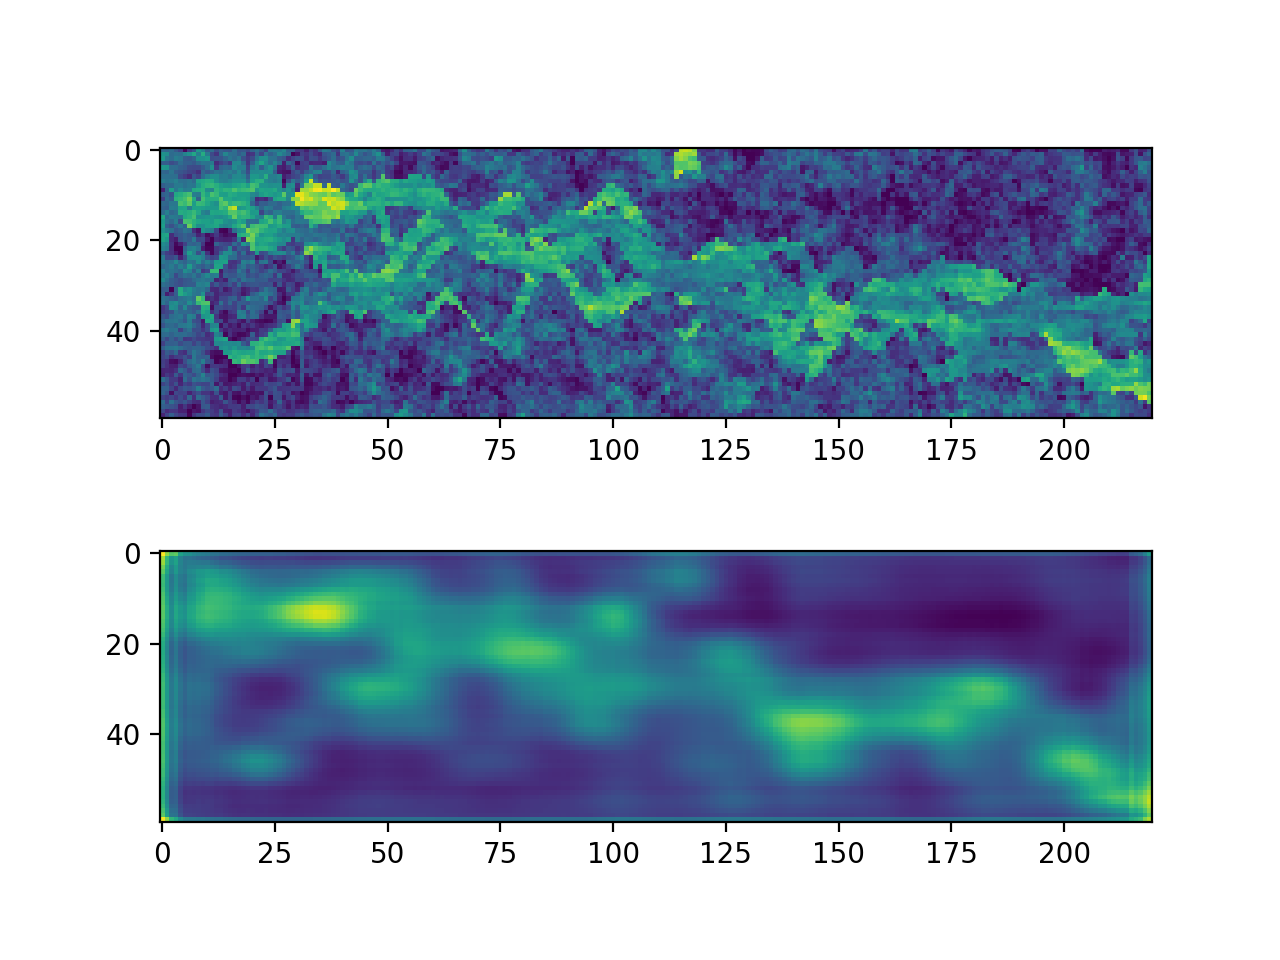

In [10]:
# check trained autoencoders
interval = np.arange(0,10)


decoded_Rock = Rautoencoder.predict(Rtest_reshaped[interval,])
animate_compare(Rtest_reshaped[interval,],decoded_Rock[:,])

## Scale data and split into sequences for RNN

In [62]:
from sklearn.preprocessing import MinMaxScaler

def change_sampling_rate(DATA,sampling_rate):
    # DATA: [n x (60*220)], n is original total sample size,75 is the original batch size
    batch_size = int(75/sampling_rate) # new batch size
    New_Data = []
    for i in range(int(len(DATA)/75)):
        temp = []
        for index in range(batch_size):
            temp.append(DATA[i*75+index*sampling_rate])
        temp = np.stack(temp)
        New_Data.append(temp)
    New_Data = np.concatenate(New_Data,axis=0)
    return New_Data, batch_size

def add_setup_data(DATA, RDATA, batch_size):
    # concatenate porosity data with states data (in encoded space)
    # [state at t1, porosity 1; state at t2, porosity 2]
    n = int(len(DATA)/batch_size) # the number of simulations
    if n != len(RDATA):
        print('ERROR: Porosity data does not match States data in length..')
        return 0
    Concatenated_Data = []
    for i in range(n):
        for j in range(batch_size):
            temp = np.concatenate([DATA[i*batch_size+j],RDATA[i]],axis=-1)
            Concatenated_Data.append(temp)
    return np.stack(Concatenated_Data)
    

def create_dataset(Batch_Data, window_len):
    """
    Batch Data must be inputed
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    """
    X_new = []
    y_new = Batch_Data[window_len:]
    for index in range(len(Batch_Data) - window_len):        
        temp = [Batch_Data[index]]
        for i in range(1,window_len):
            temp.append(Batch_Data[index+i])
        temp = np.stack(temp)
        X_new.append(temp)
    X_new = np.stack(X_new)
    y_new = np.stack(y_new)
    return X_new,y_new

def scale_data(X):
    # input original dataset samples X (x*y)
    # return normalized data and the corresponding scaler
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    print('Min:', scaler.data_min_[0:3], '\nMax: ',scaler.data_max_[0:3])
    normalized = scaler.transform(X)
    return normalized, scaler

def prepare_RNN_data(Encoded_data,lookback,batch_size):
    # assume input is encoded and outputs the tuple containing X and Y for training/ testing
    Out_X = []
    Out_y = []
    if lookback>batch_size:
        print('ERROR: Lookback window size is larger than updated batch size..')
        return 0
    for i in range(int(len(Encoded_data)/batch_size)):
        X_temp, y_temp = create_dataset(Encoded_data[i*batch_size:(i+1)*batch_size,:],lookback)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)


## LSTM-RNN

In [73]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,TRAIN,TEST,LSTM_unit,episodes,BS):
    # specify Neural Network architecture
    #     Dense1_unit = 100
    #     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    input_dims = X_train.shape[1:] # size of input
    output_dims = y_train.shape[1:]
    dim_prod = int(np.prod(X_train.shape[2:]))
#     if lookback == 1:
#         # change expected output shape if lookback is 1
#         X_train = np.expand_dims(X_train,axis = 1)
#         y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    RNN = Sequential()
    RNN.add(Reshape((lookback, dim_prod), input_shape=(input_dims)))
    RNN.add(LSTM(50, activation='relu', input_shape=(lookback,dim_prod)))
    RNN.add(Dense((dim_prod), activation = 'sigmoid'))
    RNN.add(Reshape((output_dims), input_shape=([dim_prod])))
    RNN.compile(loss='binary_crossentropy', optimizer='adam')
    history = RNN.fit(X_train, y_train, epochs=episodes, batch_size=BS-lookback, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy')
    plt.legend()
    plt.show()
    RNN.summary()
    return RNN

<IPython.core.display.Javascript object>


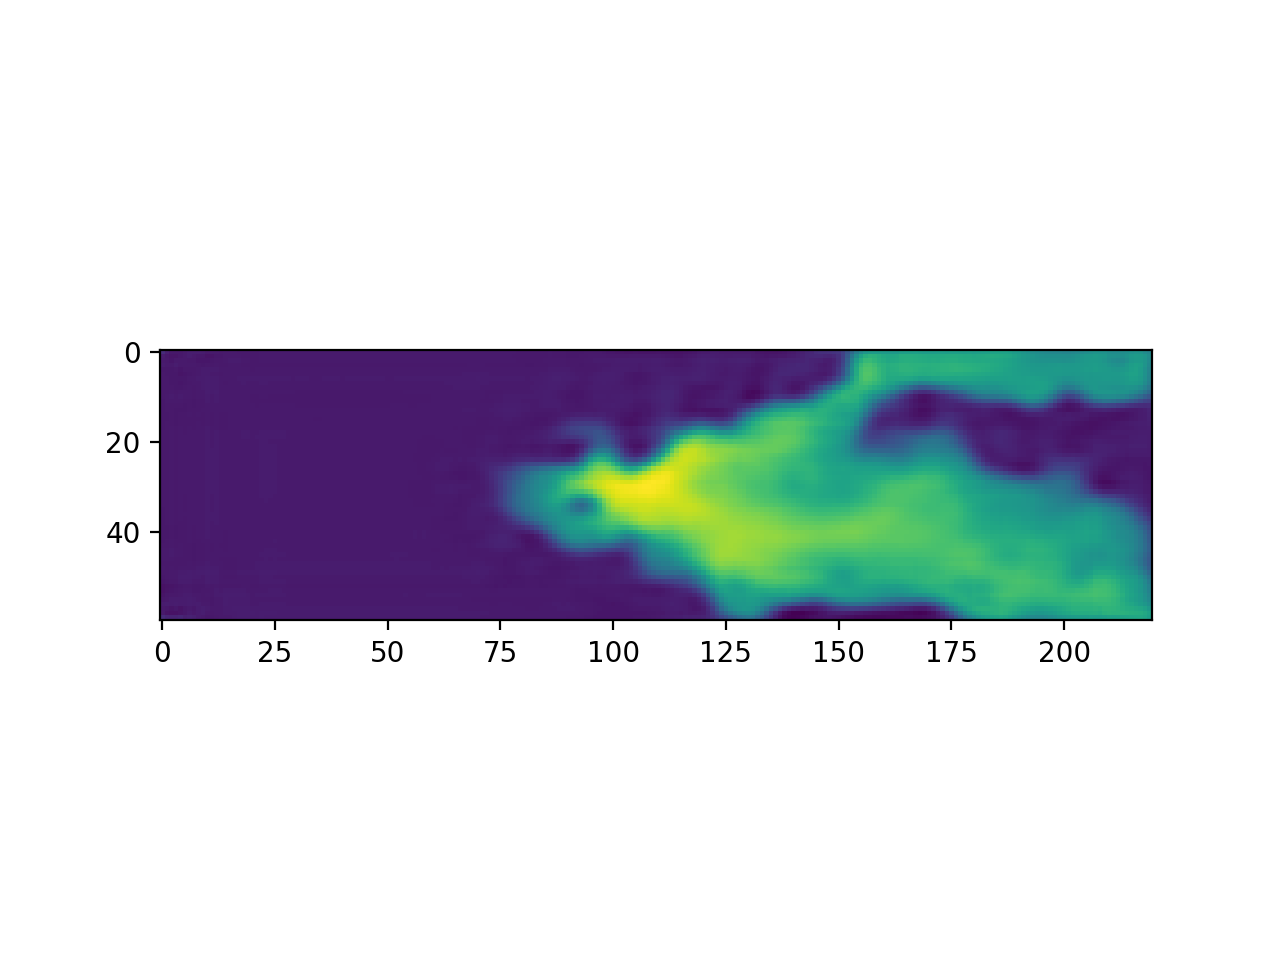

In [102]:
animate_encoded(Stest_stacked_encoded[0:75],Sdecoder,np.arange(8))

(6000, 60, 220, 1)
(6000, 8, 28, 8) (80, 8, 28, 4)
(5920, 1, 8, 28, 12)
Train on 5920 samples, validate on 1480 samples
Epoch 1/20
5920/5920 [==============================] - 16s 3ms/step - loss: 0.3950 - val_loss: 0.3346
Epoch 2/20
5920/5920 [==============================] - 8s 1ms/step - loss: 0.3347 - val_loss: 0.3343
Epoch 3/20
5920/5920 [==============================] - 8s 1ms/step - loss: 0.3346 - val_loss: 0.3343
Epoch 4/20
5920/5920 [==============================] - 9s 1ms/step - loss: 0.3346 - val_loss: 0.3342
Epoch 5/20
5920/5920 [==============================] - 8s 1ms/step - loss: 0.3345 - val_loss: 0.3341
Epoch 6/20
5920/5920 [==============================] - 8s 1ms/step - loss: 0.3343 - val_loss: 0.3340
Epoch 7/20
5920/5920 [==============================] - 8s 1ms/step - loss: 0.3340 - val_loss: 0.3337
Epoch 8/20
5920/5920 [==============================] - 8s 1ms/step - loss: 0.3336 - val_loss: 0.3333
Epoch 9/20
5920/5920 [==============================] - 9s 1ms/

<IPython.core.display.Javascript object>


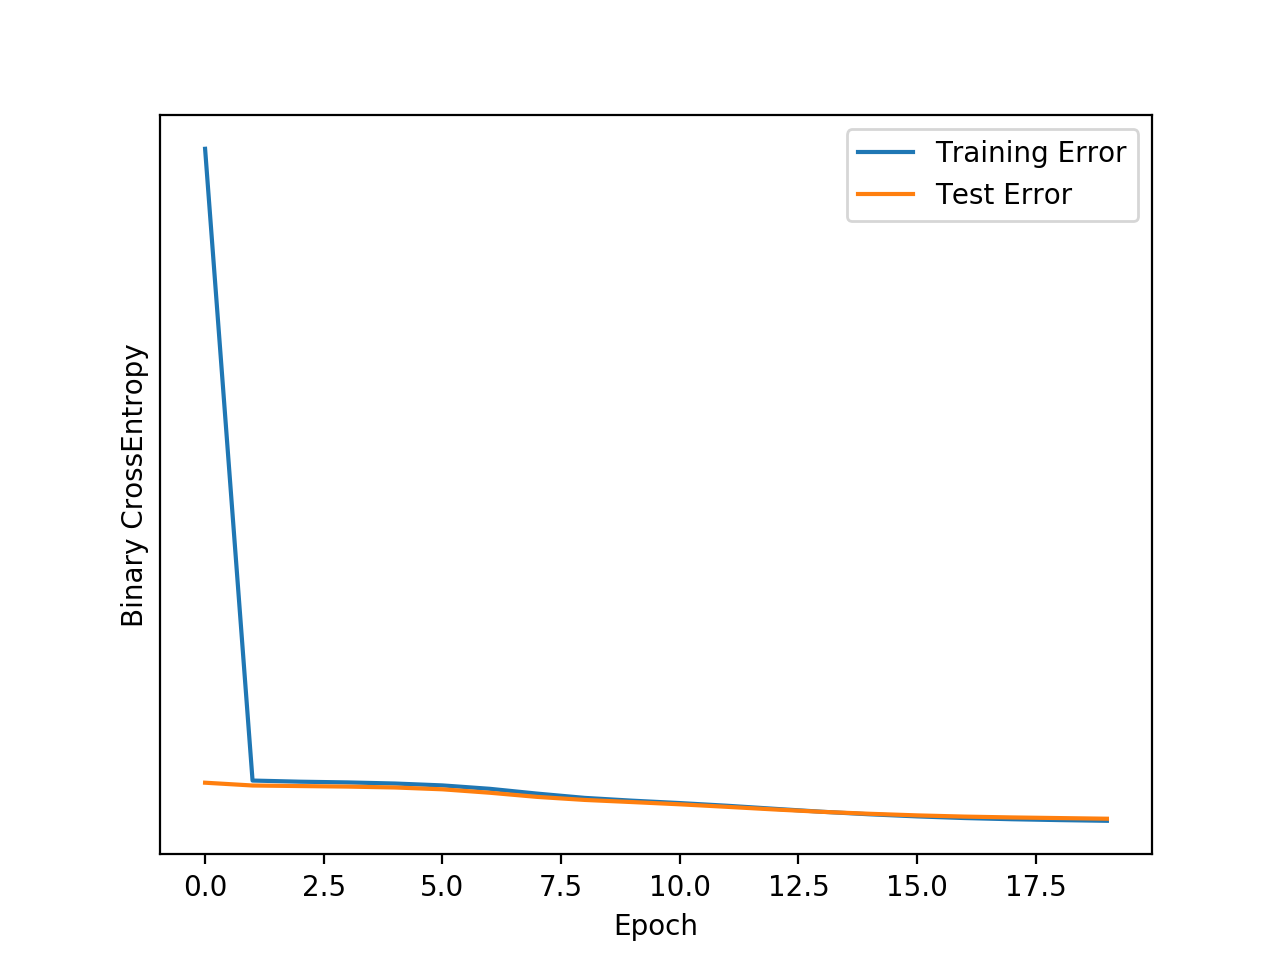

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 1, 2688)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                547800    
_________________________________________________________________
dense_5 (Dense)              (None, 2688)              137088    
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 28, 12)         0         
Total params: 684,888
Trainable params: 684,888
Non-trainable params: 0
_________________________________________________________________


In [79]:
####### SAMPLE TRAINING OF RNN FOR SATURATION (PADDED WITH ROCK POROSITY) ########

# retrieve encoders for porosity and saturation
Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', Sencoded_shape)
Rdecoder, Rencoder, Rautoencoder = retrieve_coders('R', Rencoded_shape)
# encode porosity setups
Rtrain_encoded = Rencoder.predict(Rtrain_reshaped)
Rtest_encoded = Rencoder.predict(Rtest_reshaped)
# change sampling rate of saturation states 
batch_size = 75 # default value
sampling_rate = 1 # default = 1
Stest_updated, batch_size = change_sampling_rate(Stest_reshaped,sampling_rate)
Strain_updated, batch_size = change_sampling_rate(Strain_reshaped,sampling_rate)
print(Strain_updated.shape)
# encode training and testing data
Strain_encoded = Sencoder.predict(Strain_updated)
Stest_encoded = Sencoder.predict(Stest_updated)
print(Strain_encoded.shape, Rtrain_encoded.shape)
# update encoded space by padding with setup porosity
Stest_stacked_encoded = add_setup_data(Stest_encoded, Rtest_encoded, batch_size)
Strain_stacked_encoded = add_setup_data(Strain_encoded, Rtrain_encoded, batch_size)
# transform encoded data into trainable sets
lookback = 1
STRAIN = prepare_RNN_data(Strain_stacked_encoded,lookback,batch_size)
STEST = prepare_RNN_data(Stest_stacked_encoded,lookback,batch_size)
# prepare data for validating and visualization later
STEST_single = prepare_RNN_data(Stest_encoded,lookback,batch_size) 
STEST_original = prepare_RNN_data(Stest_updated,lookback,batch_size)
print(STRAIN[0].shape)
# train model using training and testing sets
SRNN_model = trainRNN(lookback,STRAIN,STEST,50,20,batch_size)

In [72]:
# benchmark training of Feed-foward Neural Network
def trainFFN(lookback,TRAIN,TEST,Dense_unit,episodes,BS):
    # specify Neural Network architecture
    #     Dense1_unit = 100
    #     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    input_dims = X_train.shape[1:] # size of input
    output_dims = y_train.shape[1:]
    dim_prod = int(np.prod(X_train.shape[2:]))
#     if lookback == 1:
#         # change expected output shape if lookback is 1
#         X_train = np.expand_dims(X_train,axis = 1)
#         y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    FFN = Sequential()
    FFN.add(Reshape(([lookback*dim_prod]), input_shape=(input_dims)))
    FFN.add(Dense((Dense_unit), activation = 'sigmoid'))
    FFN.add(Dense((dim_prod), activation = 'sigmoid'))
    print(output_dims)
    FFN.add(Reshape((output_dims), input_shape=([dim_prod])))
    FFN.compile(loss='binary_crossentropy', optimizer='adam')
    history = FFN.fit(X_train, y_train, epochs=episodes, batch_size=BS-lookback, validation_data=(X_test, y_test), verbose=1, shuffle=True)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy')
    plt.legend()
    plt.show()
    FFN.summary()
    return FFN



## Sequential Test Functions

In [87]:
from numpy import linalg as LA
def updateX(model,X_current,lookback,Porosity_encoded):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
#     print('X_now:',X_current.shape)
    temp = []
    for i in range(len(X_current)):
        temp.append(np.concatenate([X_current[i], Porosity_encoded],axis=-1))
    X_stacked = np.stack(temp)
#     print(X_current.shape)
    X_c_train = np.expand_dims(X_stacked, axis=0)
    x_stacked_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    x_plusone = x_stacked_plusone[:,:,:,0:8]
    if lookback == 1:
        X_next = x_plusone
    else:
#         print(X_current[1:,].shape,x_plusone.shape)
        X_next = np.vstack((X_current[1:,],x_plusone))
#         print('X_next:',X_next.shape)
    return X_next,x_plusone

def cumulative_test(X_test, y_test, original_y, lookback, RNN_model, State_decoder, Porosity_encoded, batch_size):
    # perform cumulative testing
    # X_test should only have length of batch_size
    # X_test and y_test: [state_encoded]
    # error analysis and comparison will be done in the original space however
    # Porosity_encoded for the specifc interval will be used
    m = y_test.shape[0]    # total number of samples to loop through
    if m>batch_size-lookback:
        print('ERROR: X_test should have length of batch_size-lookback')
        return 0
    X_current = X_test[0,] # both X_test should be the same
    i = 0
    errors = np.zeros(m)
    predicted_y = np.zeros(original_y.shape)
    while i < m:
        X_next,y_predicted = updateX(RNN_model,X_current,lookback,Porosity_encoded)
        
        # update X and error term
        X_current = X_next
        y_predicted_original = State_decoder.predict(y_predicted)
        errors[i] = LA.norm(original_y[i,]-y_predicted_original)/LA.norm(original_y[i,])
        predicted_y[i,:] = y_predicted_original
        i += 1
    return errors, predicted_y

In [151]:
# code for reshaping the encoded space, not needed
# multiplier = 1
# original_shape = []
# Strain_encoded = encoder.predict(Strain_reshaped)

# # stretch encoded space into vector
# for i in range(1,len(Strain_encoded.shape)):
#     multiplier *= Strain_encoded.shape[i]
#     original_shape.append(Strain_encoded.shape[i])
# Strain_encoded = np.reshape(Strain_encoded, (Strain_encoded.shape[0],int(multiplier)))
# Stest_encoded = np.reshape(Stest_encoded, (Stest_encoded.shape[0],int(multiplier)))


# # reshape strectched encoded vector back to original shape for decoding
# Strain_encoded = np.reshape(Strain_encoded, tuple([Strain_encoded.shape[0]]+original_shape))
# Strain_encoded = np.reshape(Stest_encoded, tuple([Stest_encoded.shape[0]]+original_shape))
# print(Strain_encoded.shape)
# Strain_decoded = decoder.predict(Strain_encoded[0:10])
# plt.figure()
# plt.imshow(Strain_decoded[1,:,:,0])

In [230]:
# testing architecture for Feed-forward Net
FFN = Sequential()
FFN.add(Dense(100, input_shape=(1,3,1792)))
FFN.add(Dense((1792)))
FFN.compile(loss='mean_squared_error', optimizer='adam')
FFN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1, 3, 100)         179300    
_________________________________________________________________
dense_46 (Dense)             (None, 1, 3, 1792)        180992    
Total params: 360,292
Trainable params: 360,292
Non-trainable params: 0
_________________________________________________________________


In [208]:
# testing architecture for RNN
time_steps = 11
RNN = Sequential()
RNN.add(Reshape((time_steps, 1792), input_shape=(time_steps,8,28,8)))
RNN.add(LSTM(50, activation='relu', input_shape=(time_steps,1792)))
RNN.add(Dense((1792), activation = 'sigmoid'))
RNN.add(Reshape((8, 28, 8), input_shape=(1,1792)))
RNN.compile(loss='binary_crossentropy', optimizer='adam')
RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 11, 1792)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                368600    
_________________________________________________________________
dense_36 (Dense)             (None, 1792)              91392     
_________________________________________________________________
reshape_17 (Reshape)         (None, 8, 28, 8)          0         
Total params: 459,992
Trainable params: 459,992
Non-trainable params: 0
_________________________________________________________________


## Saturation Test

In [81]:
# prepare for analysis, generate data for comparison
Incre = batch_size-lookback
X,y = STEST_single
original_X, original_y = STEST_original
decoded_y = Sdecoder.predict(y)
print(y.shape,original_y.shape, decoded_y.shape)

(1480, 8, 28, 8) (1480, 60, 220, 1) (1480, 60, 220, 1)


<IPython.core.display.Javascript object>


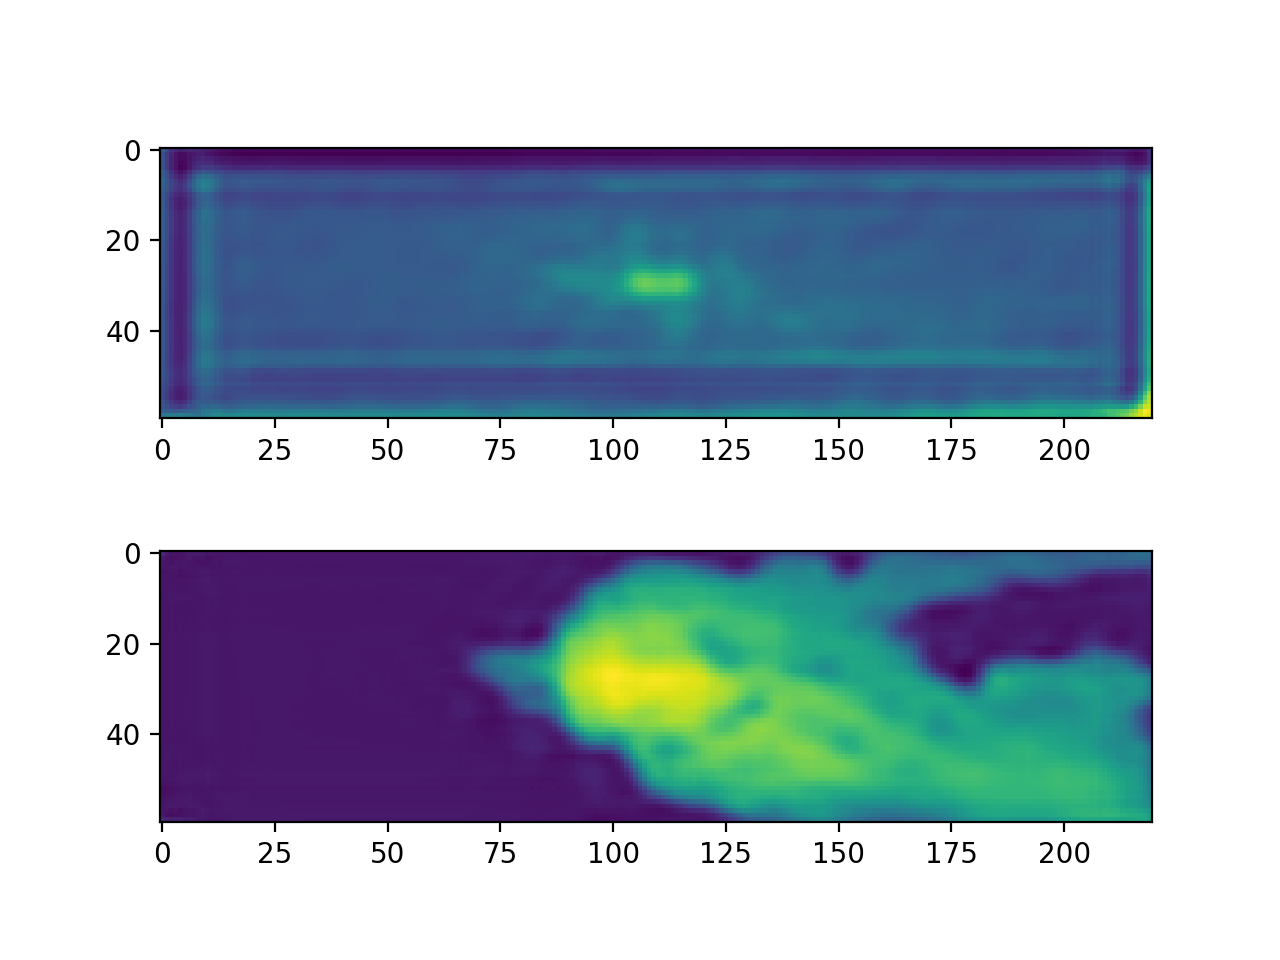

<IPython.core.display.Javascript object>


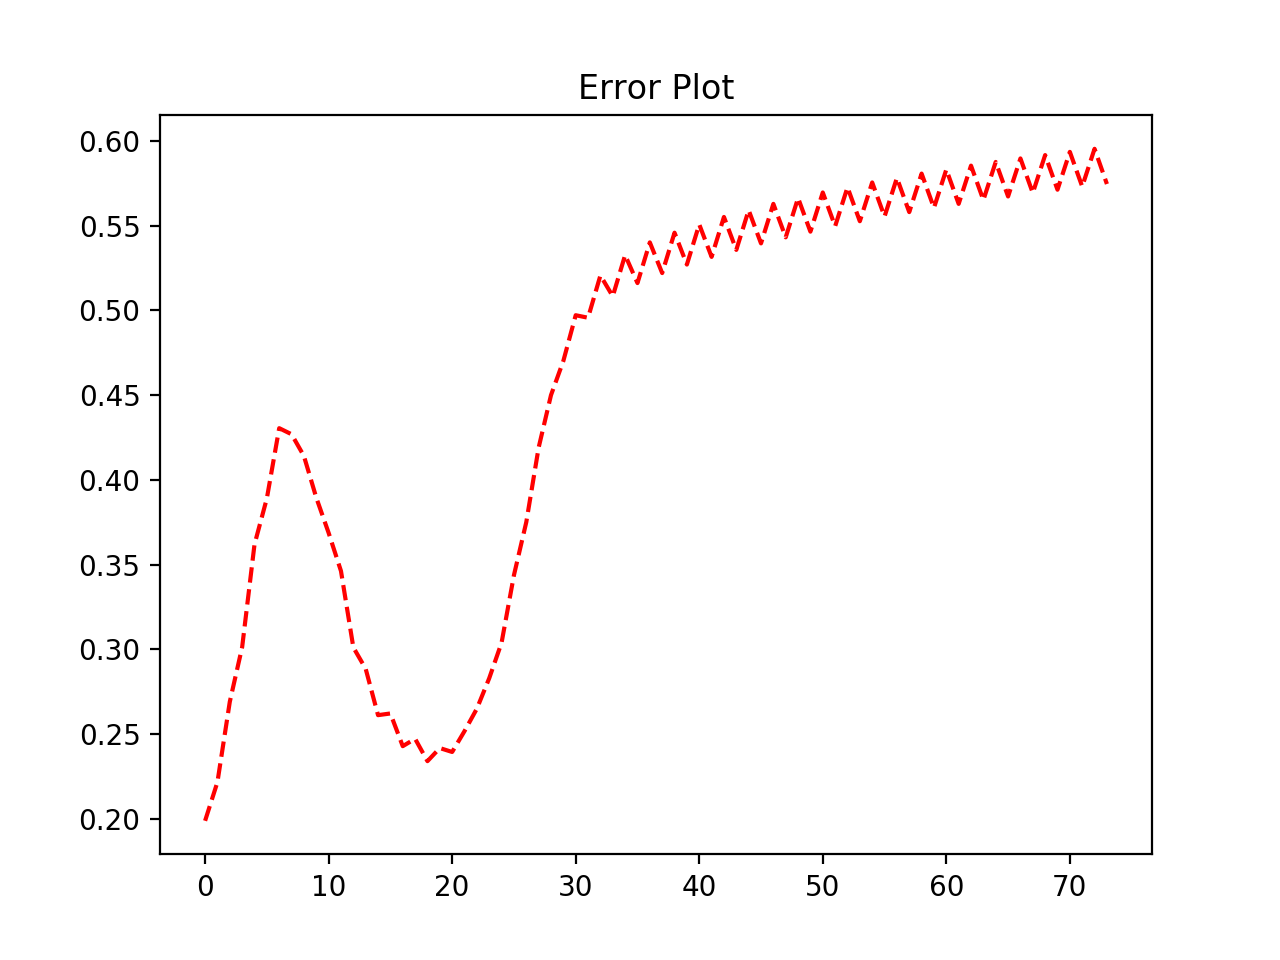

In [90]:
Interval = np.arange(Incre*2,Incre*3) # interval for testing sequentially
# switch out between decoded_y and original_y for different comparisons
errors, predicted_y = cumulative_test(X[Interval,], y[Interval,], decoded_y[Interval,], lookback, SRNN_model, 
                                      Sdecoder,Rtest_encoded[2], batch_size)
animate_compare(predicted_y,decoded_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

<IPython.core.display.Javascript object>


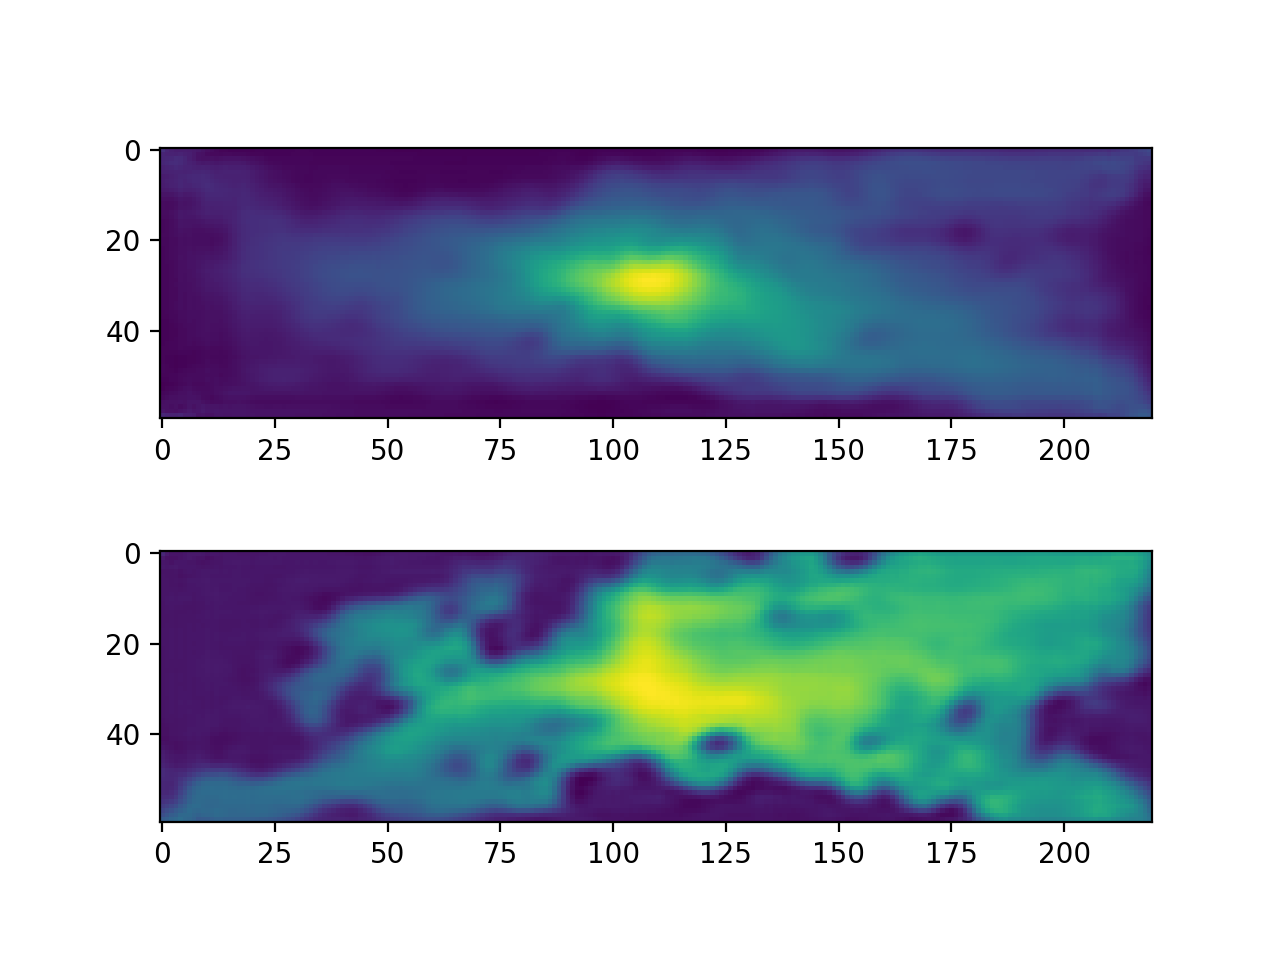

<IPython.core.display.Javascript object>


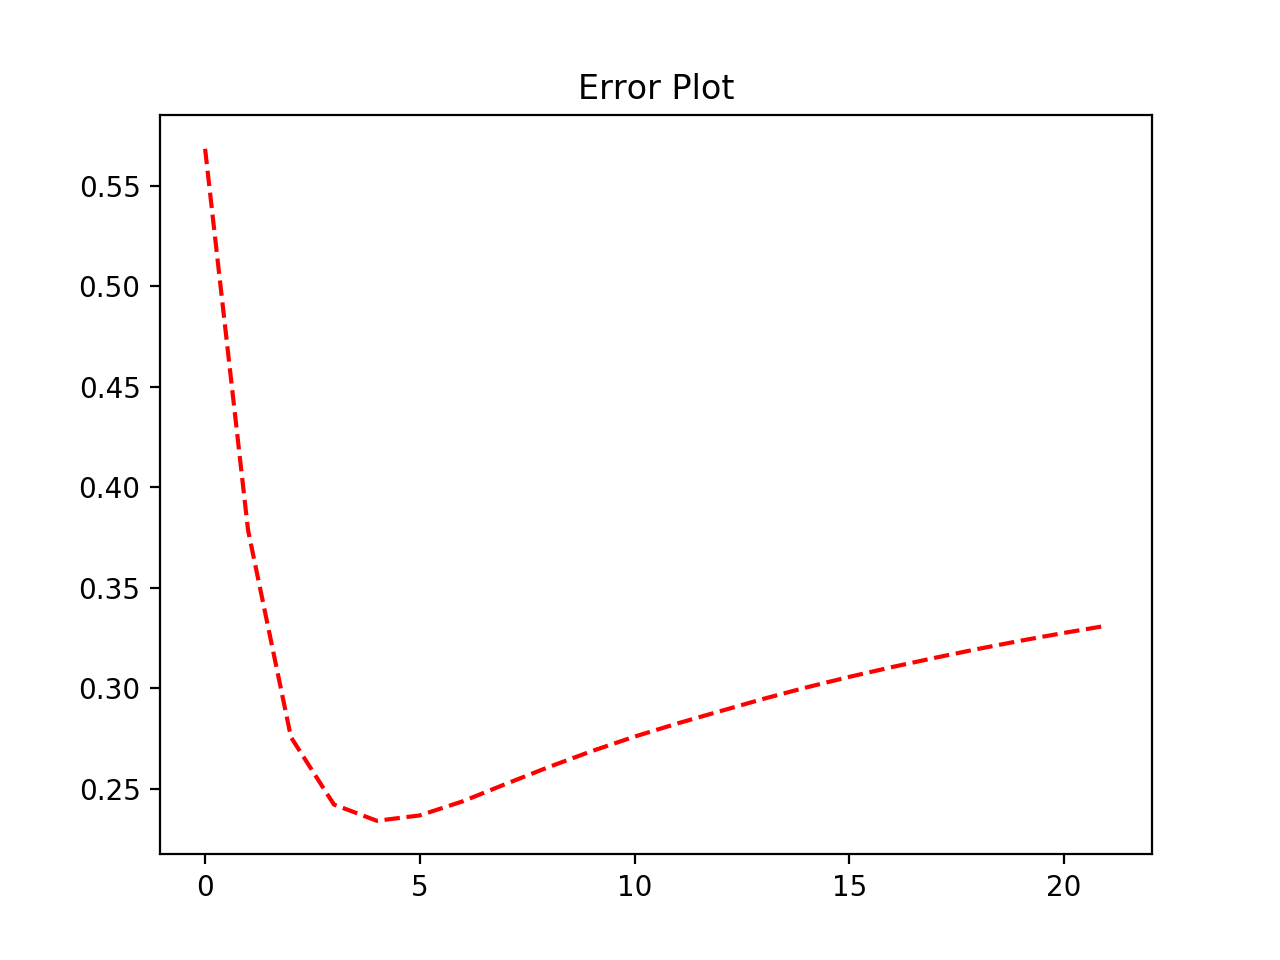

In [83]:
errors, predicted_y = cumulative_test(X[Interval,], y[Interval,], decoded_y[Interval,], lookback, FFN_model, decoder)
animate_compare(predicted_y, decoded_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

## Pressure Test

Min: [27580000. 27584000. 27588000.] 
Max:  [37017000. 52613000. 59979000.]
(6000, 60, 220, 1)


<IPython.core.display.Javascript object>


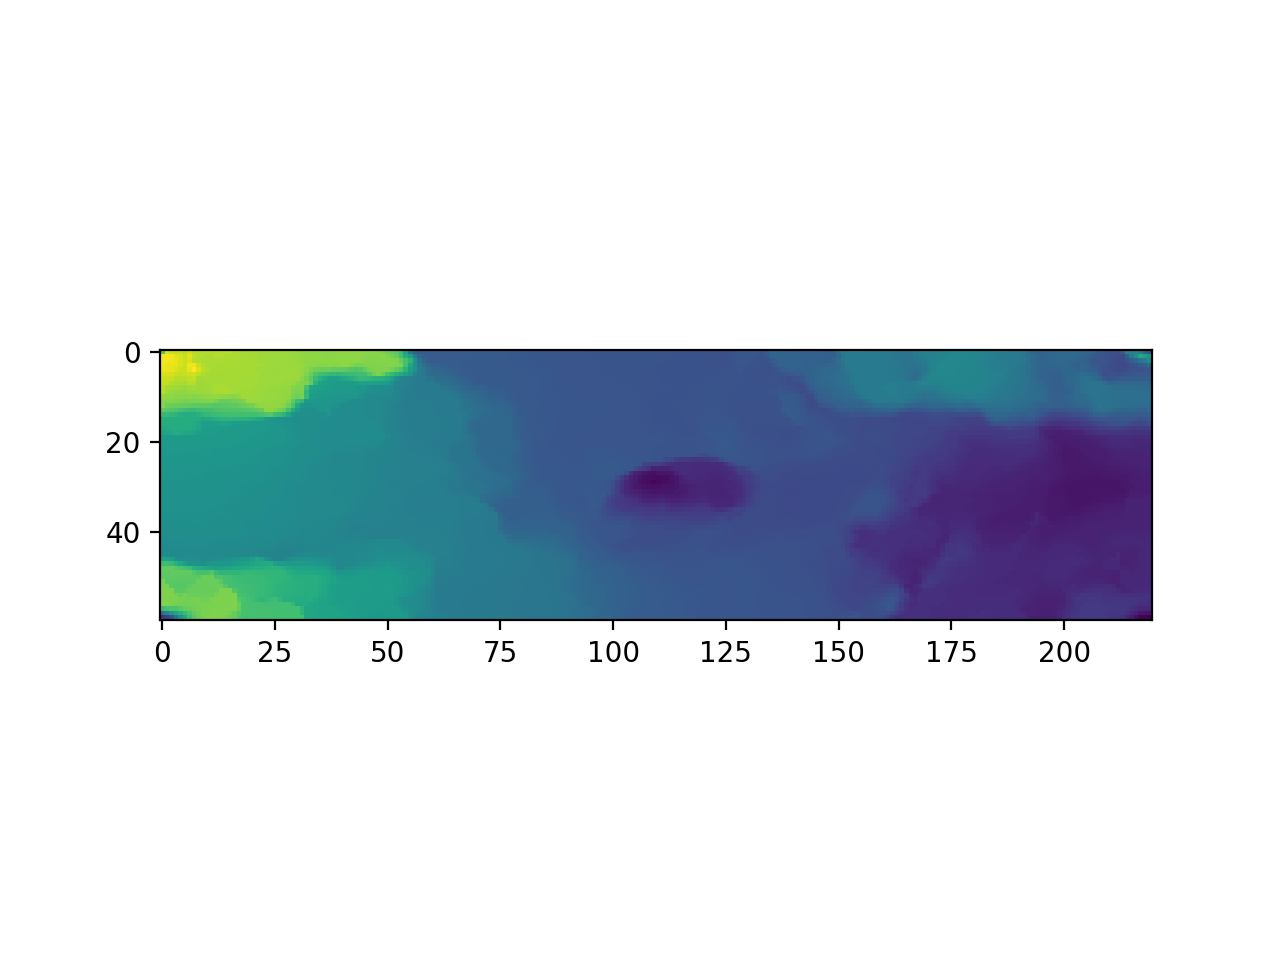

In [94]:

PTRAIN = pullseries(PRESSURE_PATH, 'pressure', np.arange(1,81))
PTEST = pullseries(PRESSURE_PATH, 'pressure', np.arange(81,101))

Ptrain, Pscaler = scale_data(PTRAIN) # scale original data
Ptest = Pscaler.transform(PTEST)

Ptrain_reshaped = np.reshape(Ptrain,(len(Ptrain), 60, 220, 1),order= 'F')
Ptest_reshaped = np.reshape(Ptest,(len(Ptest), 60, 220, 1),order= 'F')



(6000, 8, 28, 8)


<IPython.core.display.Javascript object>


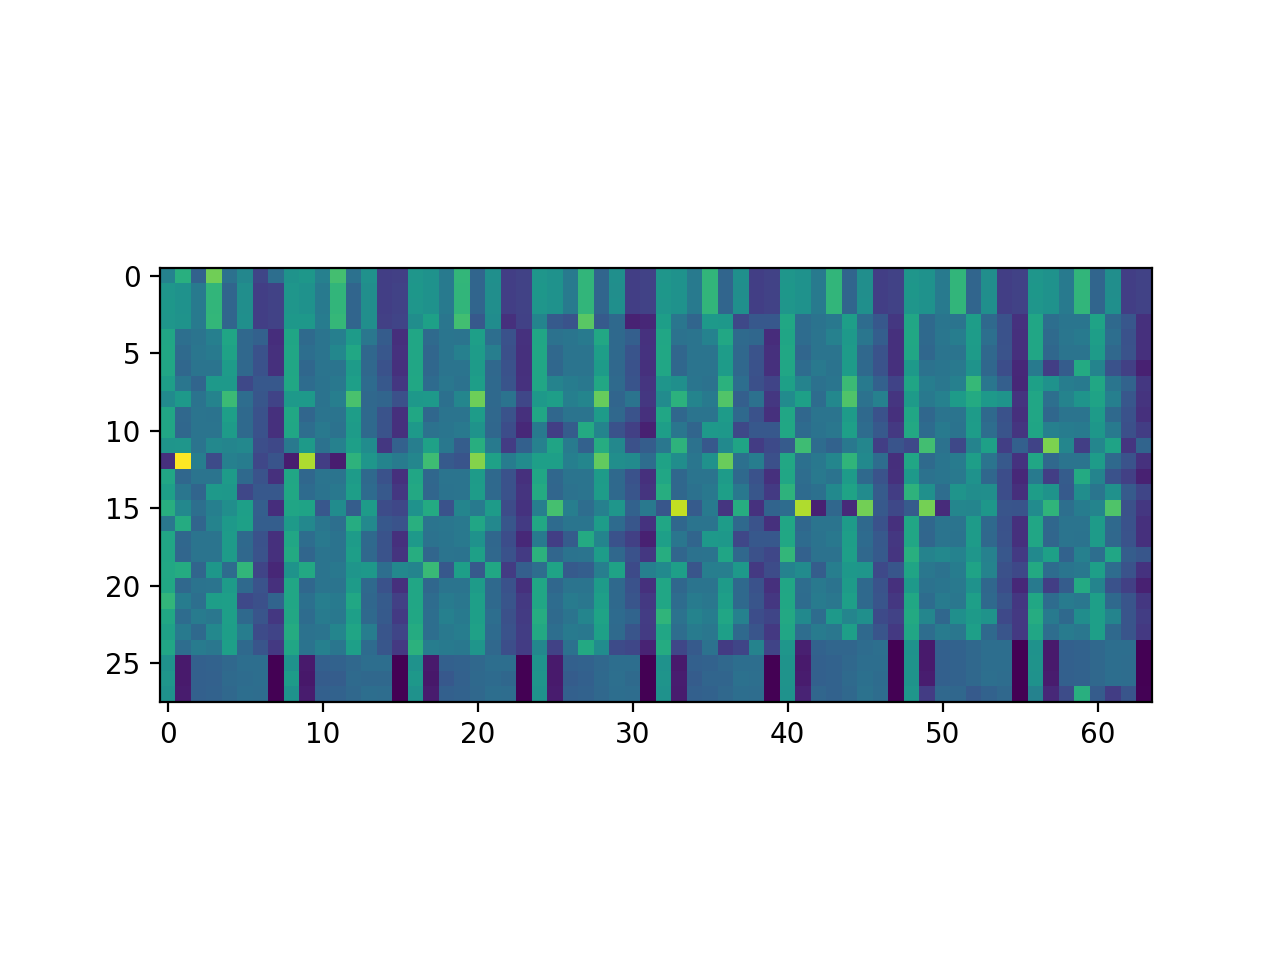

<IPython.core.display.Javascript object>


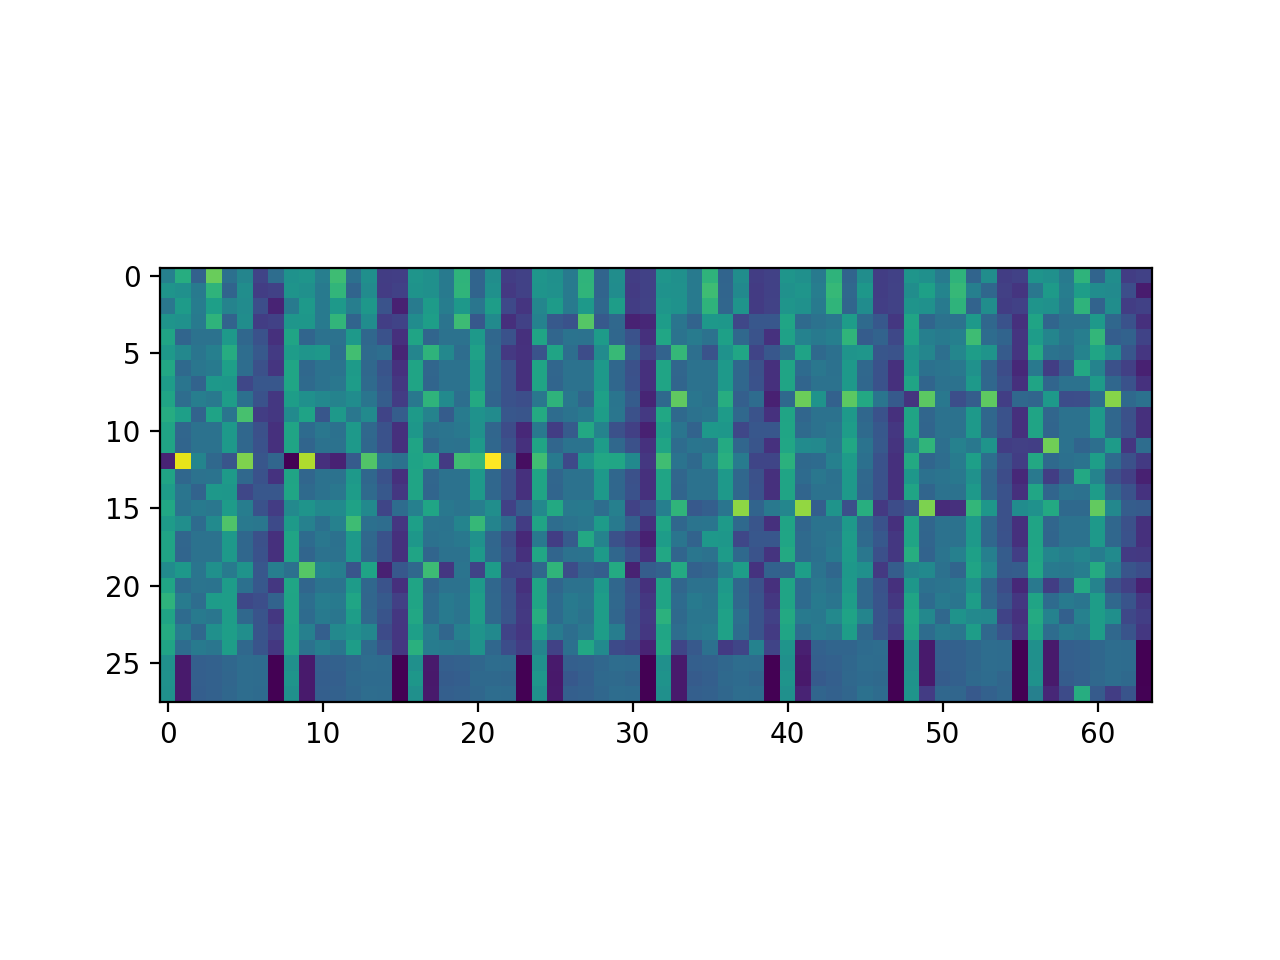

In [258]:
print(Strain_encoded.shape)
plt.figure()
plt.imshow(np.reshape(Strain_encoded[10,],(28,64)))
plt.figure()
plt.imshow(np.reshape(Strain_encoded[85,],(28,64)))